In [ ]:
import os
import importlib
#from paths_creating_and_images_copying import * ## once you have previous script downloaded, no path are needed below
import numpy as np
from datetime import datetime
import json
import keras
from keras import layers
from keras import models
from keras import Model
from keras import optimizers
from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import random
import cv2 as cv

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d mikolajbabula/disaster-images-dataset-cnn-model

100% 2.79G/2.79G [02:32<00:00, 20.5MB/s]
100% 2.79G/2.79G [02:32<00:00, 19.7MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/disaster-images-dataset-cnn-model.zip','r')
zip_ref.extractall('/content')
zip_ref.close()


In [ ]:
model_dir = '/content/DisasterModel'

cyclone_dir = r'/content/DisasterModel/Cyclone_Wildfire_Flood_Earthquake_Dataset/Cyclone'
earthquake_dir = r'/content/DisasterModel/Cyclone_Wildfire_Flood_Earthquake_Dataset/Earthquake'
flood_dir = r'/content/DisasterModel/Cyclone_Wildfire_Flood_Earthquake_Dataset/Flood'
wildfire_dir = r'/content/DisasterModel/Cyclone_Wildfire_Flood_Earthquake_Dataset/Wildfire'

train_dir = os.path.join(model_dir, 'train')
validation_dir = os.path.join(model_dir, 'validation')
test_dir = os.path.join(model_dir, 'test')

train_dir_c = os.path.join(train_dir, 'cyclone')
train_dir_e = os.path.join(train_dir, 'earthquake')
train_dir_f = os.path.join(train_dir, 'flood')
train_dir_w = os.path.join(train_dir, 'wildfire')

validation_dir_c = os.path.join(validation_dir, 'cyclone')
validation_dir_e = os.path.join(validation_dir, 'earthquake')
validation_dir_f = os.path.join(validation_dir, 'flood')
validation_dir_w = os.path.join(validation_dir, 'wildfire')

test_dir_c = os.path.join(test_dir, 'cyclone')
test_dir_e = os.path.join(test_dir, 'earthquake')
test_dir_f = os.path.join(test_dir, 'flood')
test_dir_w = os.path.join(test_dir, 'wildfire')

print('Check if samples are of same size:\n\nTrain:')
print(len(os.listdir(train_dir_c)), len(os.listdir(train_dir_e)), len(os.listdir(train_dir_f)), len(os.listdir(train_dir_w)))
print('Validation:')
print(len(os.listdir(validation_dir_c)), len(os.listdir(validation_dir_e)), len(os.listdir(validation_dir_f)), len(os.listdir(validation_dir_w)))
print('Test:')
print(len(os.listdir(test_dir_c)), len(os.listdir(test_dir_e)), len(os.listdir(test_dir_f)), len(os.listdir(test_dir_w)))

Check if samples are of same size:

Train:
400 400 400 400
Validation:
100 100 100 100
Test:
100 100 100 100


In [ ]:
model = None

model_path = '/content/model25.h5'
model_history_path = '/content/history'

model_exists = os.path.exists(model_path)
history_exists = os.path.exists(model_history_path)

if model_exists:
    model = load_model(model_path)

else:
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape= (256, 256, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation= 'relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation= 'relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(512, activation = 'relu'))
    model.add(layers.Dense(4, activation = 'softmax'))

#keras.backend.clear_session()
model.summary()

if not model_exists:
    model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['acc'])


train_datagen = ImageDataGenerator(rescale= 1./255,
                                    rotation_range= 40,
                                    width_shift_range= .2,
                                    height_shift_range= .2,
                                    shear_range= .2,
                                    zoom_range= .2,
                                    horizontal_flip= True)

test_datagen = ImageDataGenerator(rescale= 1./255,
                                    rotation_range= 40,
                                    width_shift_range= .2,
                                    height_shift_range= .2,
                                    shear_range= .2,
                                    zoom_range= .2,
                                    horizontal_flip= True)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size= (256, 256),
                                                    batch_size=8,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                    target_size=(256, 256),
                                                    batch_size=8,
                                                    class_mode='categorical')

print('\n\nCheck a size of data/label batches:')
for data_batch, label_batch in train_generator:
    print('data batch size:', data_batch.shape)
    print('label batch size:', label_batch.shape)
    break


es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=6)
mc = ModelCheckpoint('model25.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


Check a size of data/label batches:
data batch size: (8, 256, 256, 3)
label batch size: (8, 4)


In [ ]:
history = None

if history_exists:
    with open(model_history_path, 'r') as json_file:
        history = json.load(json_file)
else:
    history = model.fit(train_generator,steps_per_epoch=47, epochs=100, validation_data=validation_generator, validation_steps=47, callbacks=[es, mc]) ##in callback one can put tensorboard_callback once lines 114 and 117 are run


## with open(model_history_path, 'w') as json_file:
##     json.dump(str(history.history), json_file)

Epoch 1/100
47/47 [==============================] - ETA: 0s - loss: 1.5011 - acc: 0.3271
Epoch 1: val_acc improved from -inf to 0.38564, saving model to model25.h5
47/47 [==============================] - 34s 468ms/step - loss: 1.5011 - acc: 0.3271 - val_loss: 1.2521 - val_acc: 0.3856


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
47/47 [==============================] - ETA: 0s - loss: 1.3012 - acc: 0.3697
Epoch 2: val_acc improved from 0.38564 to 0.39096, saving model to model25.h5
47/47 [==============================] - 22s 473ms/step - loss: 1.3012 - acc: 0.3697 - val_loss: 1.2608 - val_acc: 0.3910
Epoch 3/100
47/47 [==============================] - ETA: 0s - loss: 1.2073 - acc: 0.4069
Epoch 3: val_acc improved from 0.39096 to 0.39628, saving model to model25.h5
47/47 [==============================] - 22s 482ms/step - loss: 1.2073 - acc: 0.4069 - val_loss: 1.2087 - val_acc: 0.3963
Epoch 4/100
47/47 [==============================] - ETA: 0s - loss: 1.2261 - acc: 0.4282
Epoch 4: val_acc improved from 0.39628 to 0.49468, saving model to model25.h5
47/47 [==============================] - 32s 687ms/step - loss: 1.2261 - acc: 0.4282 - val_loss: 1.2179 - val_acc: 0.4947
Epoch 5/100
47/47 [==============================] - ETA: 0s - loss: 1.1805 - acc: 0.4495
Epoch 5: val_acc improved from 0.49468 t

In [ ]:
history = model.fit(train_generator,steps_per_epoch=47, epochs=100, initial_epoch =22,validation_data=validation_generator, validation_steps=47, callbacks=[es, mc])

Epoch 23/100
47/47 [==============================] - ETA: 0s - loss: 0.6827 - acc: 0.7447
Epoch 23: val_acc did not improve from 0.81915
47/47 [==============================] - 22s 462ms/step - loss: 0.6827 - acc: 0.7447 - val_loss: 0.6208 - val_acc: 0.7819
Epoch 24/100
47/47 [==============================] - ETA: 0s - loss: 0.7504 - acc: 0.7207
Epoch 24: val_acc did not improve from 0.81915
47/47 [==============================] - 21s 447ms/step - loss: 0.7504 - acc: 0.7207 - val_loss: 1.1592 - val_acc: 0.6197
Epoch 25/100
47/47 [==============================] - ETA: 0s - loss: 0.7167 - acc: 0.7527
Epoch 25: val_acc did not improve from 0.81915
47/47 [==============================] - 22s 478ms/step - loss: 0.7167 - acc: 0.7527 - val_loss: 0.5745 - val_acc: 0.7633
Epoch 26/100
47/47 [==============================] - ETA: 0s - loss: 0.6162 - acc: 0.7713
Epoch 26: val_acc did not improve from 0.81915
47/47 [==============================] - 22s 474ms/step - loss: 0.6162 - acc: 0.77

In [ ]:
history = model.fit(train_generator,steps_per_epoch=47, epochs=100, initial_epoch = 49,validation_data=validation_generator, validation_steps=47, callbacks=[es, mc])


Epoch 50/100
47/47 [==============================] - ETA: 0s - loss: 0.5707 - acc: 0.8271
Epoch 50: val_acc did not improve from 0.86170
47/47 [==============================] - 21s 450ms/step - loss: 0.5707 - acc: 0.8271 - val_loss: 0.5229 - val_acc: 0.8404
Epoch 51/100
47/47 [==============================] - ETA: 0s - loss: 0.5907 - acc: 0.8085
Epoch 51: val_acc did not improve from 0.86170
47/47 [==============================] - 31s 677ms/step - loss: 0.5907 - acc: 0.8085 - val_loss: 0.6275 - val_acc: 0.7766
Epoch 52/100
47/47 [==============================] - ETA: 0s - loss: 0.4815 - acc: 0.8138
Epoch 52: val_acc improved from 0.86170 to 0.87766, saving model to model25.h5
47/47 [==============================] - 21s 440ms/step - loss: 0.4815 - acc: 0.8138 - val_loss: 0.3488 - val_acc: 0.8777
Epoch 53/100
47/47 [==============================] - ETA: 0s - loss: 0.5084 - acc: 0.8351
Epoch 53: val_acc did not improve from 0.87766
47/47 [==============================] - 20s 421ms

In [ ]:
history = model.fit(train_generator,steps_per_epoch=47, epochs=100, initial_epoch =58,validation_data=validation_generator, validation_steps=47, callbacks=[es, mc])


Epoch 59/100
47/47 [==============================] - ETA: 0s - loss: 0.5279 - acc: 0.7739
Epoch 59: val_acc did not improve from 0.87766
47/47 [==============================] - 32s 698ms/step - loss: 0.5279 - acc: 0.7739 - val_loss: 0.4570 - val_acc: 0.8511
Epoch 60/100
47/47 [==============================] - ETA: 0s - loss: 0.4931 - acc: 0.8511
Epoch 60: val_acc did not improve from 0.87766
47/47 [==============================] - 21s 457ms/step - loss: 0.4931 - acc: 0.8511 - val_loss: 0.5580 - val_acc: 0.8298
Epoch 61/100
47/47 [==============================] - ETA: 0s - loss: 0.4976 - acc: 0.8245
Epoch 61: val_acc did not improve from 0.87766
47/47 [==============================] - 21s 456ms/step - loss: 0.4976 - acc: 0.8245 - val_loss: 0.5373 - val_acc: 0.8218
Epoch 62/100
47/47 [==============================] - ETA: 0s - loss: 0.5708 - acc: 0.8191
Epoch 62: val_acc did not improve from 0.87766
47/47 [==============================] - 22s 468ms/step - loss: 0.5708 - acc: 0.81

In [ ]:
history = model.fit(train_generator,steps_per_epoch=47, epochs=100, initial_epoch =65,validation_data=validation_generator, validation_steps=47, callbacks=[es, mc])


Epoch 66/100
47/47 [==============================] - ETA: 0s - loss: 0.4637 - acc: 0.8644
Epoch 66: val_acc did not improve from 0.87766
47/47 [==============================] - 20s 432ms/step - loss: 0.4637 - acc: 0.8644 - val_loss: 0.4081 - val_acc: 0.8697
Epoch 67/100
47/47 [==============================] - ETA: 0s - loss: 0.5139 - acc: 0.8245
Epoch 67: val_acc did not improve from 0.87766
47/47 [==============================] - 21s 455ms/step - loss: 0.5139 - acc: 0.8245 - val_loss: 0.5779 - val_acc: 0.7819
Epoch 68/100
47/47 [==============================] - ETA: 0s - loss: 0.5313 - acc: 0.8404
Epoch 68: val_acc did not improve from 0.87766
47/47 [==============================] - 21s 460ms/step - loss: 0.5313 - acc: 0.8404 - val_loss: 0.4586 - val_acc: 0.8245
Epoch 69/100
47/47 [==============================] - ETA: 0s - loss: 0.4640 - acc: 0.8511
Epoch 69: val_acc did not improve from 0.87766
47/47 [==============================] - 21s 450ms/step - loss: 0.4640 - acc: 0.85

In [ ]:
history = model.fit(train_generator,steps_per_epoch=47, epochs=100, initial_epoch =72,validation_data=validation_generator, validation_steps=47, callbacks=[es, mc])


Epoch 73/100
47/47 [==============================] - ETA: 0s - loss: 0.5059 - acc: 0.8537
Epoch 73: val_acc did not improve from 0.87766
47/47 [==============================] - 20s 428ms/step - loss: 0.5059 - acc: 0.8537 - val_loss: 0.5526 - val_acc: 0.8005
Epoch 74/100
47/47 [==============================] - ETA: 0s - loss: 0.4596 - acc: 0.8511
Epoch 74: val_acc did not improve from 0.87766
47/47 [==============================] - 22s 465ms/step - loss: 0.4596 - acc: 0.8511 - val_loss: 0.9212 - val_acc: 0.7128
Epoch 75/100
47/47 [==============================] - ETA: 0s - loss: 0.4808 - acc: 0.8537
Epoch 75: val_acc did not improve from 0.87766
47/47 [==============================] - 21s 446ms/step - loss: 0.4808 - acc: 0.8537 - val_loss: 0.5532 - val_acc: 0.8484
Epoch 76/100
47/47 [==============================] - ETA: 0s - loss: 0.4641 - acc: 0.8431
Epoch 76: val_acc did not improve from 0.87766
47/47 [==============================] - 32s 702ms/step - loss: 0.4641 - acc: 0.84

In [ ]:
history = model.fit(train_generator,steps_per_epoch=47, epochs=100, initial_epoch =84,validation_data=validation_generator, validation_steps=47, callbacks=[es, mc])


Epoch 85/100
47/47 [==============================] - ETA: 0s - loss: 0.4801 - acc: 0.8271
Epoch 85: val_acc did not improve from 0.87766
47/47 [==============================] - 22s 464ms/step - loss: 0.4801 - acc: 0.8271 - val_loss: 0.5672 - val_acc: 0.7606
Epoch 86/100
47/47 [==============================] - ETA: 0s - loss: 0.4156 - acc: 0.8697
Epoch 86: val_acc did not improve from 0.87766
47/47 [==============================] - 21s 443ms/step - loss: 0.4156 - acc: 0.8697 - val_loss: 0.5608 - val_acc: 0.8138
Epoch 87/100
47/47 [==============================] - ETA: 0s - loss: 0.4772 - acc: 0.8431
Epoch 87: val_acc did not improve from 0.87766
47/47 [==============================] - 22s 484ms/step - loss: 0.4772 - acc: 0.8431 - val_loss: 0.5838 - val_acc: 0.8378
Epoch 88/100
47/47 [==============================] - ETA: 0s - loss: 0.4081 - acc: 0.8590
Epoch 88: val_acc did not improve from 0.87766
47/47 [==============================] - 20s 422ms/step - loss: 0.4081 - acc: 0.85

In [ ]:
model.save("disaster_manik.h5")

In [ ]:
history = model.fit(train_generator,steps_per_epoch=47, epochs=100, initial_epoch =94,validation_data=validation_generator, validation_steps=47, callbacks=[es, mc])
model.save("disaster_manik.h5")

Epoch 95/100
47/47 [==============================] - ETA: 0s - loss: 0.5015 - acc: 0.8378
Epoch 95: val_acc did not improve from 0.87766
47/47 [==============================] - 22s 475ms/step - loss: 0.5015 - acc: 0.8378 - val_loss: 0.5029 - val_acc: 0.8404
Epoch 96/100
47/47 [==============================] - ETA: 0s - loss: 0.4672 - acc: 0.8457
Epoch 96: val_acc did not improve from 0.87766
47/47 [==============================] - 20s 430ms/step - loss: 0.4672 - acc: 0.8457 - val_loss: 0.4727 - val_acc: 0.8564
Epoch 97/100
47/47 [==============================] - ETA: 0s - loss: 0.3704 - acc: 0.8830
Epoch 97: val_acc did not improve from 0.87766
47/47 [==============================] - 32s 699ms/step - loss: 0.3704 - acc: 0.8830 - val_loss: 0.5488 - val_acc: 0.8298
Epoch 98/100
47/47 [==============================] - ETA: 0s - loss: 0.6679 - acc: 0.8298
Epoch 98: val_acc did not improve from 0.87766
47/47 [==============================] - 21s 449ms/step - loss: 0.6679 - acc: 0.82

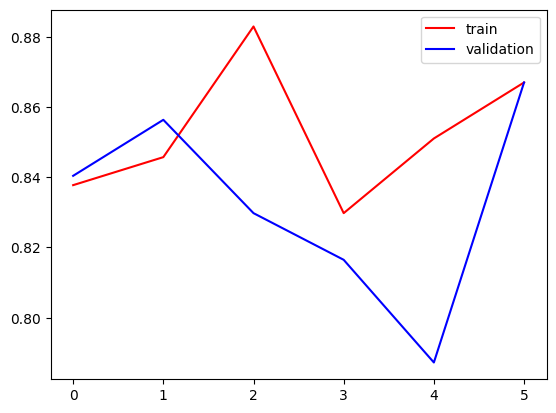

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'],color='red',label='train')
plt.plot(history.history['val_acc'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
model = None

model_path = '/content/disaster_manik.h5'
model_history_path = '/content/history'

model_exists = os.path.exists(model_path)
history_exists = os.path.exists(model_history_path)

In [ ]:
model_dir = '/content/DisasterModel'
test_dir = os.path.join(model_dir, 'test')

model_manik = '/content/disaster_manik.h5'

label_names = {0: 'cyclone', 1: 'earthquake', 2: 'flood', 3: 'wildfire'}

model = load_model(model_manik)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(256, 256), batch_size=1)

print(len(test_generator)) # [] batch_nr, [] data/labels, [] img_nr, [][] dims, [] channels

loss_test, acc_test = model.evaluate(test_generator)

print('\nThe accuracy of the model is:', str(np.round(acc_test, 2)),'% for loss value',str(np.round(loss_test, 2)),'%.')

Found 400 images belonging to 4 classes.
400
400/400 [==============================] - 14s 13ms/step - loss: 0.5438 - acc: 0.8100

The accuracy of the model is: 0.81 % for loss value 0.54 %.


1/1 [==============================] - 0s 23ms/step


Text(0.5, 1.0, 'earthquake')

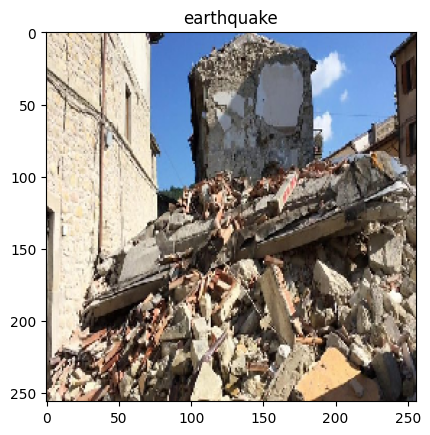

In [ ]:
idx = random.randint(0, len(test_generator)-1)
predict = model.predict(test_generator[idx][0])
plt.imshow(test_generator[idx][0][0])
plt.title(label_names[np.argmax(predict)])

In [ ]:
def run_prediction():
    n = 331
    plt.figure(figsize=(15, 15))
    for i in range(6):
        plt.subplot(n)
        idx = random.randint(0, len(test_generator)-1)
        predict = model.predict(test_generator[idx][0])
        plt.imshow(test_generator[idx][0][0])
        plt.title(label_names[np.argmax(predict)])
        n += 1

1/1 [==============================] - 0s 20ms/step


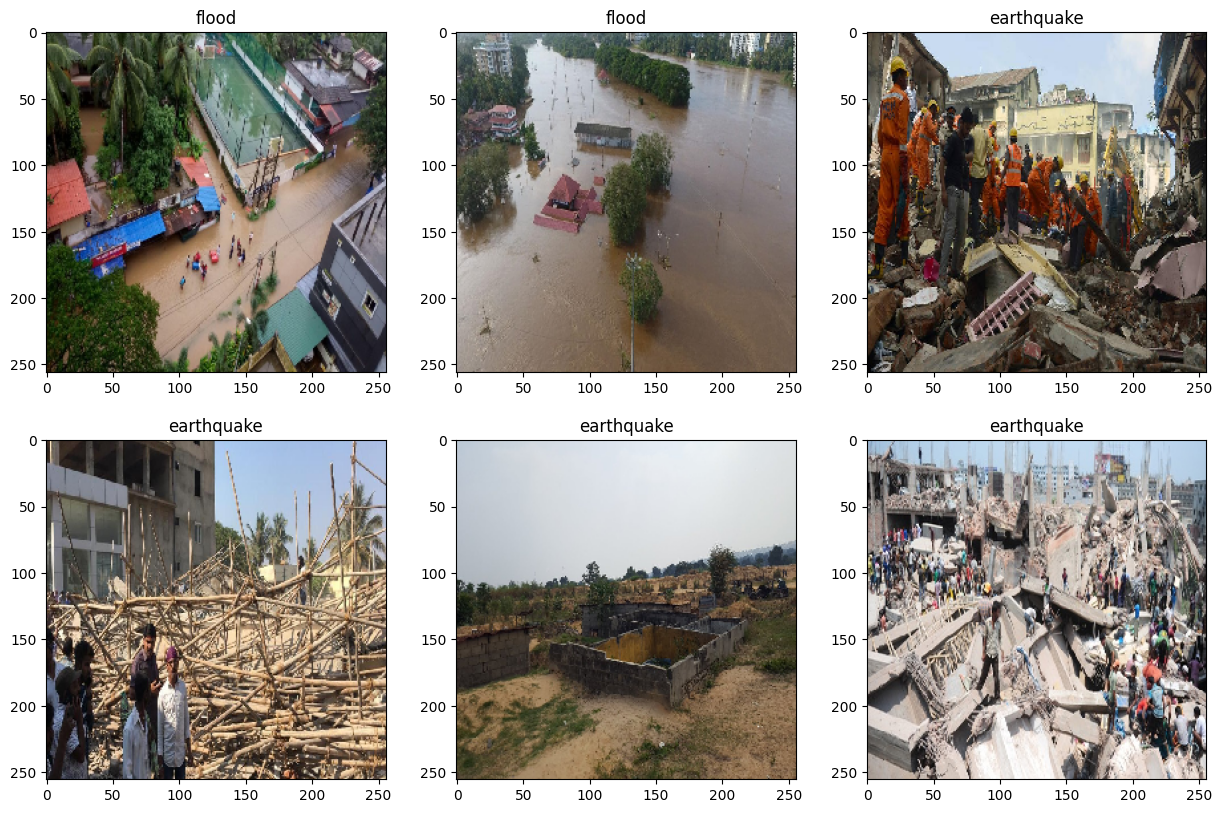

In [ ]:
run_prediction()